# Floorplan
## THIS WAS MOSTLTY USED FOR PLOTTING, SEE TASKS FOLDER INSTEAD

In [27]:
import sys
import time
import os
from os.path import join
os.environ['NUMBA_ENABLE_CUDASIM'] = '1'

import numpy as np
import matplotlib.pyplot as plt
from numba import jit, cuda

Code from simulate.py

In [60]:
def load_data(load_dir, bid):
    SIZE = 512
    u = np.zeros((SIZE + 2, SIZE + 2))
    u[1:-1, 1:-1] = np.load(join(load_dir, f"{bid}_domain.npy"))
    interior_mask = np.load(join(load_dir, f"{bid}_interior.npy"))
    return u, interior_mask


def jacobi(u, interior_mask, max_iter, atol=1e-6):
    u = np.copy(u)

    for i in range(max_iter):
        # Compute average of left, right, up and down neighbors, see eq. (1)
        u_new = 0.25 * (u[1:-1, :-2] + u[1:-1, 2:] + u[:-2, 1:-1] + u[2:, 1:-1])
        u_new_interior = u_new[interior_mask]
        delta = np.abs(u[1:-1, 1:-1][interior_mask] - u_new_interior).max()
        u[1:-1, 1:-1][interior_mask] = u_new_interior
        if delta < atol:
            break
    return u


def summary_stats(u, interior_mask):
    u_interior = u[1:-1, 1:-1][interior_mask]
    mean_temp = u_interior.mean()
    std_temp = u_interior.std()
    pct_above_18 = np.sum(u_interior > 18) / u_interior.size * 100
    pct_below_15 = np.sum(u_interior < 15) / u_interior.size * 100
    return {
        'mean_temp': mean_temp,
        'std_temp': std_temp,
        'pct_above_18': pct_above_18,
        'pct_below_15': pct_below_15,
    }


if __name__ == '__main__':
    # Load data
    LOAD_DIR = 'data'
    with open(join(LOAD_DIR, 'building_ids.txt'), 'r') as f:
        building_ids = f.read().splitlines()

    # if len(sys.argv) < 2:
    #     N = 1
    # else:
    #     N = int(sys.argv[1])
    N = 1
    building_ids = building_ids[:N]

    # Load floor plans
    all_u0 = np.empty((N, 514, 514))
    all_interior_mask = np.empty((N, 512, 512), dtype='bool')
    for i, bid in enumerate(building_ids):
        u0, interior_mask = load_data(LOAD_DIR, bid)
        all_u0[i] = u0
        all_interior_mask[i] = interior_mask

    # Run jacobi iterations for each floor plan
    MAX_ITER = 20_000
    ABS_TOL = 1e-4

    all_u = np.empty_like(all_u0)
    for i, (u0, interior_mask) in enumerate(zip(all_u0, all_interior_mask)):
        u = jacobi(u0, interior_mask, MAX_ITER, ABS_TOL)
        all_u[i] = u

    # Print summary statistics in CSV format
    stat_keys = ['mean_temp', 'std_temp', 'pct_above_18', 'pct_below_15']
    print('building_id, ' + ', '.join(stat_keys))  # CSV header
    for bid, u, interior_mask in zip(building_ids, all_u, all_interior_mask):
        stats = summary_stats(u, interior_mask)
        print(f"{bid},", ", ".join(str(stats[k]) for k in stat_keys))

## 1. & 3.

In [3]:
def process_one_image(id):
    u0, interior_mask = load_data(LOAD_DIR, id)
    u = jacobi(u0, interior_mask, MAX_ITER, ABS_TOL)
    return u0, interior_mask, u

u0_10000, interior_mask_10000, u_10000 = process_one_image('10000')
u0_48792, interior_mask_48792, u_48792 = process_one_image('48792')

In [4]:
plt.figure()
plt.subplot(3, 2, 1)
plt.imshow(u0_10000)
plt.subplot(3, 2, 2)
plt.imshow(u0_48792)

plt.subplot(3, 2, 3)
plt.imshow(interior_mask_10000)
plt.subplot(3, 2, 4)
plt.imshow(interior_mask_48792)

plt.subplot(3, 2, 5)
plt.imshow(u_10000)
plt.subplot(3, 2, 6)
plt.imshow(u_48792)

plt.show()

## 2.

For $N = 15$ it took $217.92$ sec and there are $4571$ in total, so

In [1]:
4571 / 15 * 219.92 / (60 * 60)

18.61582074074074

$18.6$ hours to process all $4571$ floorplans. 

## 4.

Kernprof for `jacobi`

    Timer unit: 1e-06 s

    Total time: 104.39 s
    File: simulate.py
    Function: jacobi at line 14

    Line #      Hits         Time  Per Hit   % Time  Line Contents
    ==============================================================
        14                                           @profile 
        15                                           def jacobi(u, interior_mask, max_iter, atol=1e-6):
        16        10      11929.5   1192.9      0.0      u = np.copy(u)
        17                                           
        18     47282      46112.0      1.0      0.0      for i in range(max_iter):
        19                                                   # Compute average of left, right, up and down neighbors, see eq. (1)
        20     47282   63932586.1   1352.2     61.2          u_new = 0.25 * (u[1:-1, :-2] + u[1:-1, 2:] + u[:-2, 1:-1] + u[2:, 1:-1])
        21     47282   10141530.4    214.5      9.7          u_new_interior = u_new[interior_mask]
        22     47282   20428426.5    432.1     19.6          delta = np.abs(u[1:-1, 1:-1][interior_mask] - u_new_interior).max()
        23     47282    9713563.0    205.4      9.3          u[1:-1, 1:-1][interior_mask] = u_new_interior
        24                                           
        25     47282     116055.2      2.5      0.1          if delta < atol:
        26        10          7.3      0.7      0.0              break
        27        10          3.1      0.3      0.0      return u

    104.39 seconds - simulate.py:14 - jacobi

Seems to be `u_new = 0.25 * (u[1:-1, :-2] + u[1:-1, 2:] + u[:-2, 1:-1] + u[2:, 1:-1])` taking 61.2%.

## 5.

In [54]:
def f(p, F):
    return 1 / (1 - F + F/p)

In [58]:
n_proc_list = [1, 2, 3, 4, 5, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]
time_list_5 = [1209.738002538681, 678.9480295181274, 470.20508766174316, 379.7852442264557, 361.1155261993408, 281.57772183418274, 246.4780752658844, 217.13096618652344, 221.3652789592743, 176.02670168876648, 179.28693056106567, 159.73765516281128, 169.87381863594055, 160.0674331188202, 153.47583508491516, 155.65933084487915, 148.86807250976562, 149.28017592430115]
speedup_list_5 = [time_list_5[0] / t for t in time_list_5]

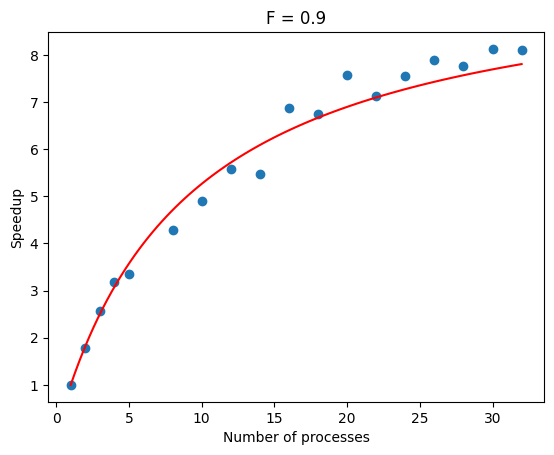

In [66]:
t = np.linspace(1, 32, 100)
F = 0.9
plt.scatter(n_proc_list, speedup_list_5)
plt.xlabel("Number of processes")
plt.ylabel("Speedup")
plt.title(f"F = {F}")
plt.plot(t, f(t, F), "r")

## 6.

In [57]:
n_proc_list = [1, 2, 3, 4, 5, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]
time_list = [1187.1531207561493, 620.6354496479034, 432.4301643371582, 369.57591462135315, 282.14162969589233, 221.43384528160095, 195.09804034233093, 174.4982042312622, 162.82645344734192, 151.47323751449585, 143.14642667770386, 137.9756953716278, 136.52406573295593, 140.9669406414032, 139.99498558044434, 142.8207709789276, 143.289781332016, 145.38458919525146]
speedup_list = [time_list[0] / t for t in time_list]
len(n_proc_list)

18

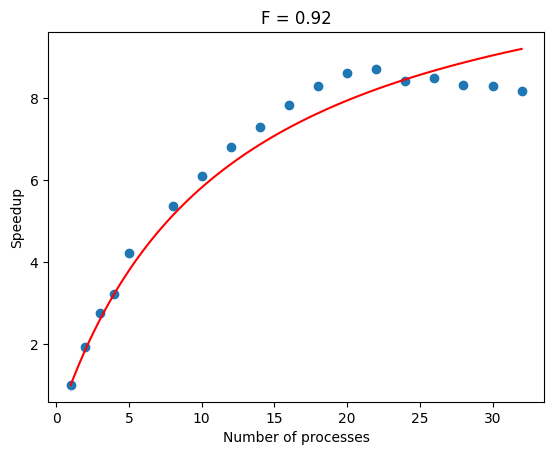

In [64]:
t = np.linspace(1, 32, 100)
F = 0.92
plt.scatter(n_proc_list, speedup_list)
plt.xlabel("Number of processes")
plt.ylabel("Speedup")
plt.title(f"F = {F}")
plt.plot(t, f(t, F), "r")

### More data! 

In [67]:
n_proc_list_6_bigger = [1, 15, 16, 18, 20, 22, 24, 26, 28, 30, 32]
time_list_6_bigger = [6151.786301136017, 660.6063425540924, 643.21812748909, 611.822696685791, 600.5984928607941, 602.8752820491791, 604.374294757843, 610.3638873100281, 612.5831010341644, 613.7921068668365, 616.471349477768]
speedup_list_6_bigger = [time_list_6_bigger[0] / t for t in time_list_6_bigger]

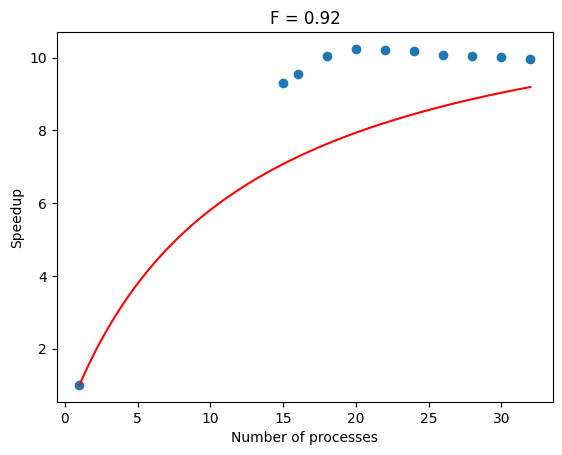

In [76]:
t = np.linspace(1, 32, 100)
F = 0.92
plt.scatter(n_proc_list_6_bigger, speedup_list_6_bigger)
plt.xlabel("Number of processes")
plt.ylabel("Speedup")
plt.title(f"F = {F}")
plt.plot(t, f(t, F), "r")

## 7.

In [6]:
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(u0_10000)

plt.subplot(1, 3, 2)
plt.imshow(interior_mask_10000)

plt.subplot(1, 3, 3)
plt.imshow(u_10000)

plt.show()

In [7]:
u0_10000.shape, interior_mask_10000.shape, u_10000.shape

In [8]:
@jit(nopython=True)
def jacobi_jit(u, interior_mask, max_iter, atol=1e-6):
    u = np.copy(u)
    for i in range(max_iter):
        # Compute average of left, right, up and down neighbors, see eq. (1)
        u_new = 0.25 * (u[1:-1, :-2] + u[1:-1, 2:] + u[:-2, 1:-1] + u[2:, 1:-1])
        u_new_interior = np.where(interior_mask, u_new, u[1:-1, 1:-1])
        delta = np.abs(u[1:-1, 1:-1] - u_new_interior).max()
        u[1:-1, 1:-1] = u_new_interior
        if delta < atol:
            break
    return u

In [ ]:
""" THIS WORKS
@jit(nopython=True)
def jacobi_jit_for_loop(u, interior_mask, max_iter, atol=1e-6):
    u = np.copy(u)
    
    n, m = u.shape
    u_new = np.copy(u)
    
    n_interior, m_interior = interior_mask.shape
    interior_mask_list = []
    for i in range(n_interior):
        for j in range(m_interior):
            if interior_mask[i, j]:
                interior_mask_list.append((i, j))
    
    # u_new_interior = np.zeros((n-2, m-2))
    u_new_interior = np.copy(u[1:-1, 1:-1])
    delta = 0
    for _ in range(max_iter):
        # for (i, j) in interior_mask_list:
        #     u_new[i, j] = 0.25 * (u[i, j-1] + u[i, j+1] + u[i-1, j] + u[i+1, j])
        
        for i in range(1, n - 1):
            for j in range(1, m - 1):
                u_new[i, j] = 0.25 * (u[i, j-1] + u[i, j+1] + u[i-1, j] + u[i+1, j])

        u_new_small = u_new[1:-1, 1:-1] 
        # u_new_interior = np.where(interior_mask, u_new_small, u[1:-1, 1:-1])
        # u_new_interior = np.copy(u[1:-1, 1:-1])
        
        ## First iteration of removing np.where
        # for i in range(1, n - 1):
        #     for j in range(1, m - 1):
        #         if interior_mask[i, j]:
        #             new_value = u_new_small[i, j]
        #             u_new_interior[i, j] = new_value
        #             # if delta < abs(u[1:-1, 1:-1][i, j] - new_value):
        #             #     delta = abs(u[1:-1, 1:-1][i, j] - new_value)
        #         else:
        #             u_new_interior[i, j] = u[1:-1, 1:-1][i, j]
        
        ## Second iteration of removing np.where
        for (i, j) in interior_mask_list:
            new_value = u_new_small[i, j]
            u_new_interior[i, j] = new_value
                    
        delta = np.abs(u[1:-1, 1:-1] - u_new_interior).max()
        u[1:-1, 1:-1] = u_new_interior
        
        if delta < atol:
            break
    
    return u
"""

In [61]:
# Cleaner version of the code above
@jit(nopython=True)
def jacobi_jit_for_loop(u, interior_mask, max_iter, atol=1e-6):
    u = np.copy(u)
    
    n, m = u.shape
    u_new = np.copy(u)
    
    n_interior, m_interior = interior_mask.shape
    interior_mask_list = []
    for i in range(n_interior):
        for j in range(m_interior):
            if interior_mask[i, j]:
                interior_mask_list.append((i, j))
    
    u_new_interior = np.copy(u[1:-1, 1:-1])
    for _ in range(max_iter):
        for i in range(1, n - 1):
            for j in range(1, m - 1):
                u_new[i, j] = 0.25 * (u[i, j-1] + u[i, j+1] + u[i-1, j] + u[i+1, j])

        u_new_small = u_new[1:-1, 1:-1] 
        for (i, j) in interior_mask_list:
            new_value = u_new_small[i, j]
            u_new_interior[i, j] = new_value

        delta = 0
        for i in range(n - 2):
            for j in range(m - 2):
                if delta < abs(u[1:-1, 1:-1][i, j] - u_new_interior[i, j]):
                    delta = abs(u[1:-1, 1:-1][i, j] - u_new_interior[i, j])
        
        u[1:-1, 1:-1] = u_new_interior
        
        if delta < atol:
            break
    
    return u

In [63]:
# Load data
LOAD_DIR = 'data'
with open(join(LOAD_DIR, 'building_ids.txt'), 'r') as f:
    building_ids = f.read().splitlines()

# if len(sys.argv) < 2:
#     N = 1
# else:
#     N = int(sys.argv[1])
N = 1
building_ids = building_ids[:N]

# Load floor plans
all_u0 = np.empty((N, 514, 514))
all_interior_mask = np.empty((N, 512, 512), dtype='bool')
for i, bid in enumerate(building_ids):
    u0, interior_mask = load_data(LOAD_DIR, bid)
    all_u0[i] = u0
    all_interior_mask[i] = interior_mask

# Run jacobi iterations for each floor plan
MAX_ITER = 20_000
ABS_TOL = 1e-4

all_u = np.empty_like(all_u0)
for i, (u0, interior_mask) in enumerate(zip(all_u0, all_interior_mask)):
    u = jacobi_jit_for_loop(u0, interior_mask, MAX_ITER, ABS_TOL)
    all_u[i] = u

# Print summary statistics in CSV format
stat_keys = ['mean_temp', 'std_temp', 'pct_above_18', 'pct_below_15']
print('building_id, ' + ', '.join(stat_keys))  # CSV header
for bid, u, interior_mask in zip(building_ids, all_u, all_interior_mask):
    stats = summary_stats(u, interior_mask)
    print(f"{bid},", ", ".join(str(stats[k]) for k in stat_keys))

building_id, mean_temp, std_temp, pct_above_18, pct_below_15
10000, 14.01233878811275, 6.367431059312565, 30.941014791508444, 55.542295034537624

From HPC, see batch-job-exercise-7-1.sh

    cat batch-output/python-hpc-02613-project-simulate-exercise-7-1_24735433.err
    Loaded module: cuda/11.8

    real    2m50.909s
    user    2m50.099s
    sys     0m0.189s

    real    7m8.695s
    user    4m34.541s
    sys     2m32.950s

    real    1m25.064s
    user    1m24.420s
    sys     0m0.261s

# 8.

In [64]:
@cuda.jit
def jacobi_kernel(u, u_new, mask):
    j, i = cuda.grid(2)  # j = col, i = row

    if 0 < i < u.shape[0] - 1 and 0 < j < u.shape[1] - 1:
        avg = 0.25 * (u[i, j - 1] + u[i, j + 1] + u[i - 1, j] + u[i + 1, j])

        # TODO: Slides be like: "avoid branching". Me: yOU cAn't tElL mE wHaT tO dO
        # If anyone feels fresh to refactor this to avoid the branching, please do so :))
        if mask[i, j]:
            u_new[i, j] = avg
        else:
            u_new[i, j] = u[i, j]


def jacobi_cuda(u, interior_mask, num_iter):
    u_cutted = np.copy(u[1:-1, 1:-1]) # Cut off the boundary
    d_u = cuda.to_device(u_cutted)
    d_u_new = cuda.device_array_like(u_cutted)
    d_mask = cuda.to_device(interior_mask)

    tpb = (32, 32)
    bpg = ((u_cutted.shape[1] + tpb[1] - 1) // tpb[1],
           (u_cutted.shape[0] + tpb[0] - 1) // tpb[0])

    for _ in range(num_iter):
        jacobi_kernel[bpg, tpb](d_u, d_u_new, d_mask)
        d_u, d_u_new = d_u_new, d_u  

    return np.pad(d_u.copy_to_host(), pad_width=1, mode='constant', constant_values=0)



In [65]:
# Load data
LOAD_DIR = 'data'
with open(join(LOAD_DIR, 'building_ids.txt'), 'r') as f:
    building_ids = f.read().splitlines()

# if len(sys.argv) < 2:
#     N = 1
# else:
#     N = int(sys.argv[1])
N = 1
building_ids = building_ids[:N]

# Load floor plans
all_u0 = np.empty((N, 514, 514))
all_interior_mask = np.empty((N, 512, 512), dtype='bool')
for i, bid in enumerate(building_ids):
    u0, interior_mask = load_data(LOAD_DIR, bid)
    all_u0[i] = u0
    all_interior_mask[i] = interior_mask

# Run jacobi iterations for each floor plan
NUM_ITER = 3_750 
ABS_TOL = 1e-4

all_u = np.empty_like(all_u0)
for i, (u0, interior_mask) in enumerate(zip(all_u0, all_interior_mask)):
    u = jacobi_cuda(u0, interior_mask, NUM_ITER)
    all_u[i] = u

# Print summary statistics in CSV format
stat_keys = ['mean_temp', 'std_temp', 'pct_above_18', 'pct_below_15']
print('building_id, ' + ', '.join(stat_keys))  # CSV header
for bid, u, interior_mask in zip(building_ids, all_u, all_interior_mask):
    stats = summary_stats(u, interior_mask)
    print(f"{bid},", ", ".join(str(stats[k]) for k in stat_keys))

## 9.

We run

    nsys profile -o simulate_9_prof python simulate_9.py 1

and then 

    nsys stats simulate_9_prof.nsys-rep

to get

    ** CUDA API Summary (cudaapisum):

    Time (%)  Total Time (ns)  Num Calls   Avg (ns)   Med (ns)   Min (ns)  Max (ns)   StdDev (ns)              Name            
    --------  ---------------  ---------  ----------  ---------  --------  ---------  -----------  ----------------------------
     56.0       9512033752    1620027      5871.5     5812.0      4141    2407293       5166.8  cuLaunchKernel              
     31.7       5388252604     341142     15794.7    15668.0      7189    1644600       3445.2  cudaMemcpyAsync             
      5.8        982373356     170556      5759.8     6154.0      4381    1383004       3514.9  cudaLaunchKernel            
      3.8        650653215     341067      1907.7     1889.0      1227     534970       1263.9  cudaStreamSynchronize       
      1.7        280940898     341097       823.6      814.0       447      24775        224.7  cudaStreamIsCapturing_v10000
      0.8        142747404         10  14274740.4   181066.0     93547  140467444   44340258.3  cudaMalloc                  
      0.1          9434559         24    393106.6   263558.0    182769    1554556     347865.1  cuModuleLoadData            
      0.0          2867385          2   1433692.5  1433692.5   1390269    1477116      61410.1  cudaHostAlloc               
      0.0          2652053         10    265205.3   107915.5     72798     956379     333050.5  cuModuleUnload              
      0.0           284225          1    284225.0   284225.0    284225     284225          0.0  cudaMemGetInfo              
      0.0           226990         59      3847.3     4866.0      1179      14351       2235.2  cudaEventQuery              
      0.0           199294         15     13286.3    10530.0      9756      36415       7129.1  cudaMemsetAsync             
      0.0           194052        768       252.7      209.0       131       3816        208.4  cuGetProcAddress            
      0.0           125589         30      4186.3     3443.0      3109      15568       2763.7  cudaEventRecord             
      0.0            82629         30      2754.3     2334.5      1927      14137       2168.2  cudaEventCreateWithFlags    
      0.0            69036         29      2380.6     2066.0      1835      11287       1719.4  cudaEventDestroy            
      0.0            10964          2      5482.0     5482.0      4794       6170        973.0  cuInit                      
      0.0             2385          3       795.0      238.0       234       1913        968.2  cuModuleGetLoadingMode      

    ** CUDA GPU Kernel Summary (gpukernsum):

    Time (%)  Total Time (ns)  Instances  Avg (ns)  Med (ns)  Min (ns)  Max (ns)  StdDev (ns)     GridXYZ         BlockXYZ                                                     Name                                                
    --------  ---------------  ---------  --------  --------  --------  --------  -----------  --------------  --------------  ----------------------------------------------------------------------------------------------------
     19.5       1903326923     255744    7442.3    7392.0      6848      8800        176.9  2048    1    1   128    1    1  cupy_add__float64_float64_float64                                                                   
     17.3       1686663005     255759    6594.7    6560.0      6112      7680        115.2   512    1    1   512    1    1  cupy_scan_naive                                                                                     
     11.9       1163253978     170511    6822.2    6848.0      6240      8032        159.6  2048    1    1   128    1    1  cupy_getitem_mask                                                                                   
     11.6       1126003790     255759    4402.6    4256.0      3744      5504        265.2   512    1    1   256    1    1  cupy_bsum_shfl                                                                                      
      9.6        933739784     255759    3650.9    3648.0      3264      4831         58.2     1    1    1   512    1    1  cupy_scan_naive                                                                                     
      6.1        591625911      85248    6940.1    6944.0      6816      7424         56.7  2048    1    1   128    1    1  cupy_scatter_update_mask                                                                            
      6.0        584484003      85248    6856.3    6880.0      6527      7424        118.5  2048    1    1   128    1    1  cupy_multiply__float_float64_float64                                                                
      3.2        315059558      85248    3695.8    3680.0      3551      9568         61.9     1    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceSingleTileKern…
      2.6        256078783      85248    3003.9    3008.0      2816      9472         98.3     1    1    1     1    1    1  cupy_less__float64_float_bool                                                                       
      1.0         96706941      15835    6107.2    6080.0      5951      7424         87.5    48    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.8         73284607      14649    5002.7    4992.0      4927      5408         63.2    51    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.7         71798643      15835    4534.2    4512.0      4479      4928         52.5   768    1    1   128    1    1  cupy_subtract__float64_float64_float64                                                              
      0.7         68746691      15835    4341.4    4320.0      4287      4768         52.4   768    1    1   128    1    1  cupy_absolute__float64_float64                                                                      
      0.5         48005578       8161    5882.3    5888.0      5696      6528        105.1    50    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.5         43955725       8832    4976.9    4960.0      4512      5408         62.0    45    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.5         43871973       8746    5016.2    4992.0      4927      6784         67.2    52    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.4         40494737       8746    4630.1    4609.0      4575      5024         42.0   824    1    1   128    1    1  cupy_subtract__float64_float64_float64                                                              
      0.4         39104565       8832    4427.6    4416.0      4352      4865         59.6   708    1    1   128    1    1  cupy_subtract__float64_float64_float64                                                              
      0.4         38841482       8746    4441.1    4416.0      4383      4831         63.0   824    1    1   128    1    1  cupy_absolute__float64_float64                                                                      
      0.4         37430084       8131    4603.4    4608.0      4543      4992         43.3   808    1    1   128    1    1  cupy_subtract__float64_float64_float64                                                              
      0.4         37426594       8161    4586.0    4576.0      4512      4993         46.4   798    1    1   128    1    1  cupy_subtract__float64_float64_float64                                                              
      0.4         37371377       8832    4231.4    4224.0      4191      4672         47.3   708    1    1   128    1    1  cupy_absolute__float64_float64                                                                      
      0.4         35875344       8131    4412.2    4385.0      4351      4864         62.0   808    1    1   128    1    1  cupy_absolute__float64_float64                                                                      
      0.4         35840003       8161    4391.6    4384.0      4320      4800         57.4   798    1    1   128    1    1  cupy_absolute__float64_float64                                                                      
      0.3         30550739       5493    5561.8    5536.0      5472      7008         60.8    39    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.3         30046619       6518    4609.8    4608.0      4544      4993         45.6   804    1    1   128    1    1  cupy_subtract__float64_float64_float64                                                              
      0.3         28715363       6518    4405.5    4384.0      4351      4800         61.6   804    1    1   128    1    1  cupy_absolute__float64_float64                                                                      
      0.3         25057662       5194    4824.3    4832.0      4735      7584         64.2    28    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.2         23397315       5493    4259.5    4256.0      4191      4704         45.5   622    1    1   128    1    1  cupy_subtract__float64_float64_float64                                                              
      0.2         23279023       4735    4916.4    4896.0      4831      5313         58.4    34    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.2         22345011       5493    4067.9    4064.0      4000      4448         36.9   622    1    1   128    1    1  cupy_absolute__float64_float64                                                                      
      0.2         21797248       4096    5321.6    5312.0      5184      5792         55.7    33    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.2         21767813       4479    4860.0    4864.0      4799      5440         44.2    23    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.2         19532517       3493    5591.9    5568.0      5439      6400         62.2    13    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.2         19339695       4735    4084.4    4064.0      4000      4511         43.6   531    1    1   128    1    1  cupy_subtract__float64_float64_float64                                                              
      0.2         18583657       4735    3924.7    3904.0      3871      4320         44.4   531    1    1   128    1    1  cupy_absolute__float64_float64                                                                      
      0.2         16618637       4479    3710.3    3712.0      3648      4128         50.0   355    1    1   128    1    1  cupy_subtract__float64_float64_float64                                                              
      0.2         16613697       4096    4056.1    4064.0      3999      4449         38.7   524    1    1   128    1    1  cupy_subtract__float64_float64_float64                                                              
      0.2         16067213       4479    3587.2    3584.0      3551      4000         55.0   355    1    1   128    1    1  cupy_absolute__float64_float64                                                                      
      0.2         15964744       4096    3897.6    3904.0      3840      4256         42.7   524    1    1   128    1    1  cupy_absolute__float64_float64                                                                      
      0.1         14037755       3602    3897.2    3903.0      3839      4257         45.8   433    1    1   128    1    1  cupy_subtract__float64_float64_float64                                                              
      0.1         13539958       3602    3759.0    3744.0      3711      4160         60.9   433    1    1   128    1    1  cupy_absolute__float64_float64                                                                      
      0.1         11814125       3493    3382.2    3360.0      3327      3776         45.9   205    1    1   128    1    1  cupy_subtract__float64_float64_float64                                                              
      0.1         11492719       3493    3290.2    3264.0      3231      3648         61.3   205    1    1   128    1    1  cupy_absolute__float64_float64                                                                      
      0.1          8422424       1535    5486.9    5472.0      5376      5888         63.1    27    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.1          6198738       1592    3893.7    3872.0      3839      4256         46.2   434    1    1   128    1    1  cupy_subtract__float64_float64_float64                                                              
      0.1          5974951       1592    3753.1    3744.0      3680      4096         56.4   434    1    1   128    1    1  cupy_absolute__float64_float64                                                                      
      0.1          5930398       1535    3863.5    3841.0      3807      4224         48.5   426    1    1   128    1    1  cupy_subtract__float64_float64_float64                                                              
      0.1          5732825       1535    3734.7    3712.0      3679      4096         54.0   426    1    1   128    1    1  cupy_absolute__float64_float64                                                                      
      0.0           558618         15   37241.2   38304.0     15680     49184      10907.6     1    1    1   512    1    1  cupy_var_core_float64                                                                               
      0.0           123072         15    8204.8    8288.0      7744      8672        306.2  2065    1    1   128    1    1  cupy_copy__float64_float64                                                                          
      0.0           104543         30    3484.8    3424.0      3360      4032        137.6     1    1    1   512    1    1  cupy_cub_sum_pass2                                                                                  
      0.0           100702         15    6713.5    6624.0      6592      7424        219.5  2048    1    1   128    1    1  cupy_copy__float64_float64                                                                          
      0.0            99227         30    3307.6    3263.0      3104      3905        226.1     1    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceSingleTileKern…
      0.0            89915         30    2997.2    2976.0      2943      3328         85.0     1    1    1     1    1    1  cupy_true_divide__int64_int_float64                                                                 
      0.0            89887         30    2996.2    2976.0      2912      3200         73.9     1    1    1     1    1    1  cupy_true_divide__float64_float_float64                                                             
      0.0            88032         30    2934.4    2912.0      2879      3200         74.2     1    1    1     1    1    1  cupy_multiply__float64_float_float64                                                                
      0.0            45023         15    3001.5    2976.0      2944      3328        103.5     1    1    1     1    1    1  cupy_sqrt__float64_float64                                                                          
      0.0            44190         15    2946.0    2912.0      2880      3296        101.5     1    1    1     1    1    1  cupy_copy__float64_float64                                                                          
      0.0            18463          4    4615.8    4576.0      4448      4863        183.1    48    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0            16544          4    4136.0    4144.5      3775      4480        348.1    28    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0            15904          4    3976.0    3968.0      3936      4032         40.3    51    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0            14656          4    3664.0    3616.0      3552      3872        141.9    48    1    1   512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0            14623          4    3655.8    3648.0      3456      3871        214.1    28    1    1   512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0            14497          4    3624.3    3536.0      3521      3904        187.0    51    1    1   512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0             9343          2    4671.5    4671.5      4159      5184        724.8    39    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0             9057          2    4528.5    4528.5      4225      4832        429.2    50    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0             9056          2    4528.0    4528.0      4224      4832        429.9    52    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0             8864          2    4432.0    4432.0      4320      4544        158.4   768    1    1   128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             8608          2    4304.0    4304.0      4288      4320         22.6   768    1    1   128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             8512          2    4256.0    4256.0      3840      4672        588.3    13    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0             8064          2    4032.0    4032.0      3968      4096         90.5    27    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0             8000          2    4000.0    4000.0      3872      4128        181.0    33    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0             7968          2    3984.0    3984.0      3969      3999         21.2    45    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0             7616          2    3808.0    3808.0      3776      3840         45.3    34    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0             7552          2    3776.0    3776.0      3712      3840         90.5    23    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0             7296          2    3648.0    3648.0      3488      3808        226.3    39    1    1   512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0             7136          2    3568.0    3568.0      3456      3680        158.4    27    1    1   512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0             7136          2    3568.0    3568.0      3552      3584         22.6    50    1    1   512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0             7136          2    3568.0    3568.0      3552      3584         22.6    52    1    1   512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0             7040          2    3520.0    3520.0      3520      3520          0.0    45    1    1   512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0             6976          2    3488.0    3488.0      3455      3521         46.7    13    1    1   512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0             6976          2    3488.0    3488.0      3456      3520         45.3    33    1    1   512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0             6975          2    3487.5    3487.5      3487      3488          0.7    23    1    1   512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0             6944          2    3472.0    3472.0      3456      3488         22.6    34    1    1   512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0             4416          1    4416.0    4416.0      4416      4416          0.0   824    1    1   128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             4384          1    4384.0    4384.0      4384      4384          0.0   808    1    1   128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             4384          1    4384.0    4384.0      4384      4384          0.0   824    1    1   128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             4384          1    4384.0    4384.0      4384      4384          0.0   804    1    1   128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             4384          1    4384.0    4384.0      4384      4384          0.0   808    1    1   128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             4383          1    4383.0    4383.0      4383      4383          0.0   798    1    1   128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             4352          1    4352.0    4352.0      4352      4352          0.0   798    1    1   128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             4352          1    4352.0    4352.0      4352      4352          0.0   804    1    1   128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             4225          1    4225.0    4225.0      4225      4225          0.0   708    1    1   128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             4224          1    4224.0    4224.0      4224      4224          0.0   622    1    1   128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             4192          1    4192.0    4192.0      4192      4192          0.0   708    1    1   128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             4192          1    4192.0    4192.0      4192      4192          0.0   524    1    1   128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             4031          1    4031.0    4031.0      4031      4031          0.0   622    1    1   128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             3905          1    3905.0    3905.0      3905      3905          0.0   531    1    1   128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             3873          1    3873.0    3873.0      3873      3873          0.0   531    1    1   128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             3872          1    3872.0    3872.0      3872      3872          0.0   433    1    1   128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             3872          1    3872.0    3872.0      3872      3872          0.0   524    1    1   128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             3841          1    3841.0    3841.0      3841      3841          0.0   433    1    1   128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             3744          1    3744.0    3744.0      3744      3744          0.0   426    1    1   128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             3711          1    3711.0    3711.0      3711      3711          0.0   434    1    1   128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             3681          1    3681.0    3681.0      3681      3681          0.0   434    1    1   128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             3680          1    3680.0    3680.0      3680      3680          0.0   426    1    1   128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             3648          1    3648.0    3648.0      3648      3648          0.0   355    1    1   128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             3552          1    3552.0    3552.0      3552      3552          0.0   355    1    1   128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             3264          1    3264.0    3264.0      3264      3264          0.0   205    1    1   128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             3264          1    3264.0    3264.0      3264      3264          0.0   205    1    1   128    1    1  cupy_greater__float64_float_bool                                                                    


    ** GPU MemOps Summary (by Time) (gpumemtimesum):

    Time (%)  Total Time (ns)  Count   Avg (ns)  Med (ns)  Min (ns)  Max (ns)  StdDev (ns)      Operation     
    --------  ---------------  ------  --------  --------  --------  --------  -----------  ------------------
        99.3        457609051  341067    1341.7    1313.0      1279      2080         60.2  [CUDA memcpy DtoH]
        0.6          2972864      30   99095.5   98782.5     24000    190046      76270.6  [CUDA memcpy HtoD]
        0.1           363259      45    8072.4    9280.0      3199     13312       3615.4  [CUDA memcpy DtoD]
        0.0            72481      15    4832.1    4896.0      4384      5473        367.6  [CUDA memset]     


    ** GPU MemOps Summary (by Size) (gpumemsizesum):

    Total (MB)  Count   Avg (MB)  Med (MB)  Min (MB)  Max (MB)  StdDev (MB)      Operation     
    ----------  ------  --------  --------  --------  --------  -----------  ------------------
        67.339      45     1.496     2.114     0.262     2.114        0.883  [CUDA memcpy DtoD]
        35.389      30     1.180     1.180     0.262     2.097        0.933  [CUDA memcpy HtoD]
        31.704      15     2.114     2.114     2.114     2.114        0.000  [CUDA memset]     
        1.109  341067     0.000     0.000     0.000     0.000        0.000  [CUDA memcpy DtoH]

## 10.

In [19]:
A = np.array([
    [
        [1, 2, 3],
        [4, 5, 6],
        [4, 3, 5]
    ],
    [
        [4, 5, 1],
        [9, 4, 1],
        [7, 5, 8]
    ]
])
A0 = A[0]
A, A.shape, A0

(array([[[1, 2, 3],
         [4, 5, 6],
         [4, 3, 5]],
 
        [[4, 5, 1],
         [9, 4, 1],
         [7, 5, 8]]]),
 (2, 3, 3),
 array([[1, 2, 3],
        [4, 5, 6],
        [4, 3, 5]]))

In [25]:
"""
0.25 * (u[1:-1, :-2] + u[1:-1, 2:] + u[:-2, 1:-1] + u[2:, 1:-1])
"""
A[0][1:-1, :-2], A[1][1:-1, :-2], A[:, 1:-1, :-2]

(array([[4]]),
 array([[9]]),
 array([[[4]],
 
        [[9]]]))

### Same as in 9.

     ** CUDA API Summary (cudaapisum):

    Time (%)  Total Time (ns)  Num Calls   Avg (ns)   Med (ns)   Min (ns)  Max (ns)   StdDev (ns)              Name            
    --------  ---------------  ---------  ----------  ---------  --------  ---------  -----------  ----------------------------
     55.6       4999166131     898568      5563.5     5488.0      3902    1387852       4049.0  cuLaunchKernel              
     31.2       2804229903     189228     14819.3    14703.0      6616     205210       1527.3  cudaMemcpyAsync             
      5.9        531193079      94604      5614.9     5910.0      4199    1349441       4483.7  cudaLaunchKernel            
      4.0        360849379     189178      1907.5     1890.0      1209     389878        956.7  cudaStreamSynchronize       
      1.7        155562752     189198       822.2      809.0       458     624155       1451.4  cudaStreamIsCapturing_v10000
      1.4        124333940         10  12433394.0   152429.0     92392  122688549   38739830.1  cudaMalloc                  
      0.1          6685507         24    278562.8   169646.0    105369    1251999     305882.5  cuModuleLoadData            
      0.0          2831836          2   1415918.0  1415918.0   1380216    1451620      50490.3  cudaHostAlloc               
      0.0          2157093         10    215709.3    89866.5     56113     808939     285197.3  cuModuleUnload              
      0.0           143160         39      3670.8     4322.0      1368      11202       1935.2  cudaEventQuery              
      0.0           128390         10     12839.0     9221.5      8472      38064       9105.4  cudaMemsetAsync             
      0.0           100271        384       261.1      216.5       138       1069        120.7  cuGetProcAddress            
      0.0            82600         20      4130.0     3336.0      3012      12191       2271.5  cudaEventRecord             
      0.0            59360          1     59360.0    59360.0     59360      59360          0.0  cudaMemGetInfo              
      0.0            56017         20      2800.9     2309.5      2131      10363       1822.9  cudaEventCreateWithFlags    
      0.0            36652         19      1929.1     1819.0      1740       3769        448.7  cudaEventDestroy            
      0.0             2637          1      2637.0     2637.0      2637       2637          0.0  cuInit                      
      0.0             1414          2       707.0      707.0       276       1138        609.5  cuModuleGetLoadingMode      

    Processing [simulate_9_prof.sqlite] with [/appl/cuda/11.8.0/nsight-systems-2022.4.2/host-linux-x64/reports/gpukernsum.py]... 

    ** CUDA GPU Kernel Summary (gpukernsum):

    Time (%)  Total Time (ns)  Instances  Avg (ns)  Med (ns)  Min (ns)  Max (ns)  StdDev (ns)     GridXYZ         BlockXYZ                                                     Name                                                
    --------  ---------------  ---------  --------  --------  --------  --------  -----------  --------------  --------------  ----------------------------------------------------------------------------------------------------
     19.7       1053365961     141846    7426.1    7360.0      6688      8576        213.1  2048    1    1   128    1    1  cupy_add__float64_float64_float64                                                                   
     17.4        928770956     141856    6547.3    6496.0      6048      7712        109.7   512    1    1   512    1    1  cupy_scan_naive                                                                                     
     12.0        641264963      94574    6780.6    6816.0      6209      7904        166.1  2048    1    1   128    1    1  cupy_getitem_mask                                                                                   
     11.5        616813105     141856    4348.2    4192.0      3776      5472        274.6   512    1    1   256    1    1  cupy_bsum_shfl                                                                                      
      9.5        510732796     141856    3600.4    3584.0      3200      4865         56.2     1    1    1   512    1    1  cupy_scan_naive                                                                                     
      6.1        326196211      47282    6899.0    6880.0      6560      7392         54.8  2048    1    1   128    1    1  cupy_scatter_update_mask                                                                            
      6.0        322834089      47282    6827.8    6847.0      6463      7360         92.7  2048    1    1   128    1    1  cupy_multiply__float_float64_float64                                                                
      3.2        171907060      47282    3635.8    3617.0      3519      6207         60.7     1    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceSingleTileKern…
      2.6        139034322      47282    2940.5    2912.0      2783      3520         96.4     1    1    1     1    1    1  cupy_less__float64_float_bool                                                                       
      1.8         95786735      15835    6049.1    6048.0      5887      7167         93.8    48    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      1.3         71055433      15835    4487.2    4480.0      4415      4896         51.8   768    1    1   128    1    1  cupy_subtract__float64_float64_float64                                                              
      1.3         67727024      15835    4277.0    4257.0      4223      4704         49.6   768    1    1   128    1    1  cupy_absolute__float64_float64                                                                      
      0.6         32479266       6518    4983.0    4960.0      4895      5376         62.0    51    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.6         30439596       5493    5541.5    5536.0      5151      6720         58.6    39    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.6         29661130       6518    4550.6    4544.0      4480      4959         46.0   804    1    1   128    1    1  cupy_subtract__float64_float64_float64                                                              
      0.5         28333892       6518    4347.0    4351.0      4287      4767         54.2   804    1    1   128    1    1  cupy_absolute__float64_float64                                                                      
      0.5         24694262       5194    4754.4    4737.0      4351      7488         55.4    28    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.4         23113034       5493    4207.7    4192.0      4128      4608         50.6   622    1    1   128    1    1  cupy_subtract__float64_float64_float64                                                              
      0.4         23064875       4735    4871.1    4864.0      4799      5280         46.6    34    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.4         22048301       5493    4013.9    4000.0      3967      4353         39.7   622    1    1   128    1    1  cupy_absolute__float64_float64                                                                      
      0.4         21376120       4479    4772.5    4768.0      4703      5248         35.9    23    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.4         19246111       3493    5509.9    5504.0      5343      6337         58.3    13    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.4         19108731       4735    4035.6    4032.0      3936      4415         38.8   531    1    1   128    1    1  cupy_subtract__float64_float64_float64                                                              
      0.3         18328889       4735    3870.9    3872.0      3807      4256         50.0   531    1    1   128    1    1  cupy_absolute__float64_float64                                                                      
      0.3         16377397       4479    3656.5    3648.0      3615      4064         51.7   355    1    1   128    1    1  cupy_subtract__float64_float64_float64                                                              
      0.3         15796779       4479    3526.9    3520.0      3487      3936         41.5   355    1    1   128    1    1  cupy_absolute__float64_float64                                                                      
      0.3         13830561       3602    3839.7    3840.0      3775      4288         50.8   433    1    1   128    1    1  cupy_subtract__float64_float64_float64                                                              
      0.2         13283852       3602    3687.9    3680.0      3647      4096         52.2   433    1    1   128    1    1  cupy_absolute__float64_float64                                                                      
      0.2         11635820       3493    3331.2    3328.0      3264      3745         49.4   205    1    1   128    1    1  cupy_subtract__float64_float64_float64                                                              
      0.2         11228908       3493    3214.7    3200.0      3167      3648         55.0   205    1    1   128    1    1  cupy_absolute__float64_float64                                                                      
      0.2          8400008       1535    5472.3    5472.0      5376      5856         53.4    27    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.1          6113522       1592    3840.2    3840.0      3775      4223         49.3   434    1    1   128    1    1  cupy_subtract__float64_float64_float64                                                              
      0.1          5875862       1592    3690.9    3680.0      3328      4096         52.6   434    1    1   128    1    1  cupy_absolute__float64_float64                                                                      
      0.1          5840338       1535    3804.8    3808.0      3743      4160         53.7   426    1    1   128    1    1  cupy_subtract__float64_float64_float64                                                              
      0.1          5627360       1535    3666.0    3648.0      3615      4000         49.5   426    1    1   128    1    1  cupy_absolute__float64_float64                                                                      
      0.0           338429         10   33842.9   30960.0     15872     48159      11010.6     1    1    1   512    1    1  cupy_var_core_float64                                                                               
      0.0            82911         10    8291.1    8288.0      7872      8576        241.2  2065    1    1   128    1    1  cupy_copy__float64_float64                                                                          
      0.0            68926         20    3446.3    3392.0      3328      3807        122.6     1    1    1   512    1    1  cupy_cub_sum_pass2                                                                                  
      0.0            66751         10    6675.1    6592.0      6560      7392        256.1  2048    1    1   128    1    1  cupy_copy__float64_float64                                                                          
      0.0            65692         20    3284.6    3215.5      3071      3840        259.1     1    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceSingleTileKern…
      0.0            59296         20    2964.8    2912.0      2880      3168        105.4     1    1    1     1    1    1  cupy_true_divide__float64_float_float64                                                             
      0.0            58689         20    2934.5    2912.0      2880      3072         55.0     1    1    1     1    1    1  cupy_true_divide__int64_int_float64                                                                 
      0.0            57405         20    2870.3    2848.0      2784      3264         99.7     1    1    1     1    1    1  cupy_multiply__float64_float_float64                                                                
      0.0            29761         10    2976.1    2928.5      2880      3296        127.1     1    1    1     1    1    1  cupy_sqrt__float64_float64                                                                          
      0.0            28896         10    2889.6    2848.0      2816      3136        102.4     1    1    1     1    1    1  cupy_copy__float64_float64                                                                          
      0.0            18240          4    4560.0    4496.0      4416      4832        196.4    48    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0            16254          4    4063.5    4064.0      3711      4415        327.4    28    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0            14432          4    3608.0    3568.0      3392      3904        244.2    28    1    1   512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0            14113          4    3528.3    3536.5      3456      3584         65.8    48    1    1   512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0             9280          2    4640.0    4640.0      4064      5216        814.6    39    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0             8577          2    4288.5    4288.5      4288      4289          0.7   768    1    1   128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             8480          2    4240.0    4240.0      4224      4256         22.6   768    1    1   128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             8159          2    4079.5    4079.5      3776      4383        429.2    13    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0             7937          2    3968.5    3968.5      3873      4064        135.1    27    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0             7776          2    3888.0    3888.0      3872      3904         22.6    51    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0             7648          2    3824.0    3824.0      3808      3840         22.6    34    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0             7488          2    3744.0    3744.0      3680      3808         90.5    23    1    1   256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0             7040          2    3520.0    3520.0      3520      3520          0.0    51    1    1   512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0             6943          2    3471.5    3471.5      3423      3520         68.6    39    1    1   512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0             6913          2    3456.5    3456.5      3424      3489         46.0    13    1    1   512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0             6881          2    3440.5    3440.5      3424      3457         23.3    34    1    1   512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0             6816          2    3408.0    3408.0      3392      3424         22.6    23    1    1   512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0             6815          2    3407.5    3407.5      3392      3423         21.9    27    1    1   512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0             4320          1    4320.0    4320.0      4320      4320          0.0   804    1    1   128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             4288          1    4288.0    4288.0      4288      4288          0.0   804    1    1   128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             4160          1    4160.0    4160.0      4160      4160          0.0   622    1    1   128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             3968          1    3968.0    3968.0      3968      3968          0.0   622    1    1   128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             3936          1    3936.0    3936.0      3936      3936          0.0   433    1    1   128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             3872          1    3872.0    3872.0      3872      3872          0.0   426    1    1   128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             3840          1    3840.0    3840.0      3840      3840          0.0   531    1    1   128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             3840          1    3840.0    3840.0      3840      3840          0.0   531    1    1   128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             3776          1    3776.0    3776.0      3776      3776          0.0   426    1    1   128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             3776          1    3776.0    3776.0      3776      3776          0.0   433    1    1   128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             3648          1    3648.0    3648.0      3648      3648          0.0   434    1    1   128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             3616          1    3616.0    3616.0      3616      3616          0.0   434    1    1   128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             3487          1    3487.0    3487.0      3487      3487          0.0   355    1    1   128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             3456          1    3456.0    3456.0      3456      3456          0.0   355    1    1   128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             3200          1    3200.0    3200.0      3200      3200          0.0   205    1    1   128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             3168          1    3168.0    3168.0      3168      3168          0.0   205    1    1   128    1    1  cupy_less__float64_float_bool                                                                       

    Processing [simulate_9_prof.sqlite] with [/appl/cuda/11.8.0/nsight-systems-2022.4.2/host-linux-x64/reports/gpumemtimesum.py]... 

    ** GPU MemOps Summary (by Time) (gpumemtimesum):

    Time (%)  Total Time (ns)  Count   Avg (ns)  Med (ns)  Min (ns)  Max (ns)  StdDev (ns)      Operation     
    --------  ---------------  ------  --------  --------  --------  --------  -----------  ------------------
     99.1        242805022  189178    1283.5    1280.0       896      1888         59.9  [CUDA memcpy DtoH]
      0.8          1970671      20   98533.6   98575.5     23904    173599      76371.7  [CUDA memcpy HtoD]
      0.1           245246      30    8174.9    9328.0      3136     14688       3844.7  [CUDA memcpy DtoD]
      0.0            48224      10    4822.4    4784.0      4576      5184        243.2  [CUDA memset]     

    Processing [simulate_9_prof.sqlite] with [/appl/cuda/11.8.0/nsight-systems-2022.4.2/host-linux-x64/reports/gpumemsizesum.py]... 

    ** GPU MemOps Summary (by Size) (gpumemsizesum):

    Total (MB)  Count   Avg (MB)  Med (MB)  Min (MB)  Max (MB)  StdDev (MB)      Operation     
    ----------  ------  --------  --------  --------  --------  -----------  ------------------
     44.893      30     1.496     2.114     0.262     2.114        0.888  [CUDA memcpy DtoD]
     23.593      20     1.180     1.180     0.262     2.097        0.941  [CUDA memcpy HtoD]
     21.136      10     2.114     2.114     2.114     2.114        0.000  [CUDA memset]     
      0.615  189178     0.000     0.000     0.000     0.000        0.000  [CUDA memcpy DtoH]

### For 10.

    ** CUDA API Summary (cudaapisum):

    Time (%)  Total Time (ns)  Num Calls   Avg (ns)   Med (ns)   Min (ns)  Max (ns)   StdDev (ns)              Name            
    --------  ---------------  ---------  ----------  ---------  --------  ---------  -----------  ----------------------------
     51.9       1510050752      31950     47262.9    26341.5      6609     758426      44184.1  cudaMemcpyAsync             
     37.3       1087049767     199326      5453.6     5323.0      3870     403801       1416.9  cuLaunchKernel              
      4.3        124837015         12  10403084.6   156161.0     88829  122804944   35397491.3  cudaMalloc                  
      3.0         87647171      15970      5488.2     6031.0      4091      70165       1287.4  cudaLaunchKernel            
      2.1         62261077      31910      1951.1     1938.0      1189      21406        369.2  cudaStreamSynchronize       
      0.9         27044105      31930       847.0      839.0       454      10507        228.5  cudaStreamIsCapturing_v10000
      0.2          6518757         26    250721.4   133932.5    107906    1206878     287877.7  cuModuleLoadData            
      0.1          2826209          2   1413104.5  1413104.5   1382248    1443961      43637.7  cudaHostAlloc               
      0.1          2381445         12    198453.8    95082.5     61299     775126     252117.6  cuModuleUnload              
      0.0           129920         39      3331.3     4031.0      1281       7342       1500.4  cudaEventQuery              
      0.0           128853         10     12885.3     9439.0      8834      37401       8814.3  cudaMemsetAsync             
      0.0           101300        384       263.8      210.0       143       1190        130.9  cuGetProcAddress            
      0.0            72428         20      3621.4     3241.0      3036       8461       1210.5  cudaEventRecord             
      0.0            56128          1     56128.0    56128.0     56128      56128          0.0  cudaMemGetInfo              
      0.0            55908         20      2795.4     2247.0      2101      11712       2115.4  cudaEventCreateWithFlags    
      0.0            35554         19      1871.3     1749.0      1612       3987        517.8  cudaEventDestroy            
      0.0             4633          1      4633.0     4633.0      4633       4633          0.0  cuInit                      
      0.0             1604          2       802.0      802.0       197       1407        855.6  cuModuleGetLoadingMode      

    Processing [simulate_10_prof.sqlite] with [/appl/cuda/11.8.0/nsight-systems-2022.4.2/host-linux-x64/reports/gpukernsum.py]... 

    ** CUDA GPU Kernel Summary (gpukernsum):

    Time (%)  Total Time (ns)  Instances  Avg (ns)  Med (ns)  Min (ns)  Max (ns)  StdDev (ns)      GridXYZ         BlockXYZ                                                     Name                                                
    --------  ---------------  ---------  --------  --------  --------  --------  -----------  ---------------  --------------  ----------------------------------------------------------------------------------------------------
     34.6       1701259013      23895   71197.3   78751.0     54943     80223      11006.5  20480    1    1   128    1    1  cupy_add__float64_float64_float64                                                                   
     17.7        866627496      23895   36268.2   36192.0     35712     40832        496.8  5120    1    1    512    1    1  cupy_scan_naive                                                                                     
     11.9        586304347      15930   36805.0   36768.0     35807     41024        586.0  20480    1    1   128    1    1  cupy_getitem_mask                                                                                   
      8.9        434929144       7965   54605.0   54591.0     53952     55903        247.2  20480    1    1   128    1    1  cupy_multiply__float_float64_float64                                                                
      6.5        318488885       7965   39986.0   39968.0     39072     42944        426.0  20480    1    1   128    1    1  cupy_scatter_update_mask                                                                            
      6.5        317445619      23895   13285.0   13216.0     12384     15328        489.8  5120    1    1    256    1    1  cupy_bsum_shfl                                                                                      
      3.6        177778122       7965   22319.9   22304.0     21632     23488        254.1  5342    1    1    128    1    1  cupy_subtract__float64_float64_float64                                                              
      2.5        124735197       7965   15660.4   15616.0     14784     17152        297.9  5342    1    1    128    1    1  cupy_absolute__float64_float64                                                                      
      1.7         84760245       7965   10641.6   10656.0      9536     12864        290.8   334    1    1    256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      1.7         82544904      23895    3454.5    3455.0      3391      4257         67.5    10    1    1    512    1    1  cupy_scan_naive                                                                                     
      1.7         81885390      23905    3425.5    3392.0      3296      4864         73.8     1    1    1    512    1    1  cupy_scan_naive                                                                                     
      1.5         73404277      23895    3072.0    3135.0      2847      3808        142.5    10    1    1    256    1    1  cupy_bsum_shfl                                                                                      
      0.7         33732079       7965    4235.0    4192.0      3872      7040         95.5     1    1    1    256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceSingleTileKern…
      0.5         24914437       7965    3128.0    3104.0      3071      3744         75.1     1    1    1      1    1    1  cupy_less__float64_float_bool                                                                       
      0.0           304413         10   30441.3   27871.5     14048     43840       9919.0     1    1    1    512    1    1  cupy_var_core_float64                                                                               
      0.0            66720         10    6672.0    6592.0      6560      7392        257.4  2048    1    1    128    1    1  cupy_copy__float64_float64                                                                          
      0.0            62655         20    3132.8    3072.0      3008      3455        122.7     1    1    1    512    1    1  cupy_cub_sum_pass2                                                                                  
      0.0            61599         10    6159.9    6127.5      6016      6400        140.2  2048    1    1    128    1    1  cupy_getitem_mask                                                                                   
      0.0            60928         10    6092.8    5888.0      5824      7104        398.3   512    1    1    512    1    1  cupy_scan_naive                                                                                     
      0.0            59712         20    2985.6    2912.5      2816      3521        238.4     1    1    1    256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceSingleTileKern…
      0.0            55999          1   55999.0   55999.0     55999     55999          0.0  20641    1    1   128    1    1  cupy_copy__float64_float64                                                                          
      0.0            54014         20    2700.7    2656.0      2592      2912         91.5     1    1    1      1    1    1  cupy_true_divide__float64_float_float64                                                             
      0.0            52896         20    2644.8    2640.0      2591      2784         49.0     1    1    1      1    1    1  cupy_true_divide__int64_int_float64                                                                 
      0.0            52672         20    2633.6    2608.5      2559      2880         74.3     1    1    1      1    1    1  cupy_multiply__float64_float_float64                                                                
      0.0            40351         10    4035.1    3936.0      3904      4352        159.9   512    1    1    256    1    1  cupy_bsum_shfl                                                                                      
      0.0            27039         10    2703.9    2656.0      2624      2848         80.2     1    1    1      1    1    1  cupy_sqrt__float64_float64                                                                          
      0.0            26847         10    2684.7    2624.0      2592      2912        121.2     1    1    1      1    1    1  cupy_copy__float64_float64                                                                          
      0.0            16736          4    4184.0    4128.0      4032      4448        189.1    48    1    1    256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0            14592          4    3648.0    3632.0      3328      4000        323.2    28    1    1    256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0            13153          4    3288.3    3280.5      3104      3488        196.4    28    1    1    512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0            12833          4    3208.3    3216.0      3137      3264         65.6    48    1    1    512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0             8352          2    4176.0    4176.0      3712      4640        656.2    39    1    1    256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0             7776          2    3888.0    3888.0      3872      3904         22.6   768    1    1    128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             7776          2    3888.0    3888.0      3872      3904         22.6   768    1    1    128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             7424          2    3712.0    3712.0      3456      3968        362.0    13    1    1    256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0             7359          2    3679.5    3679.5      3520      3839        225.6    51    1    1    256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0             7232          2    3616.0    3616.0      3552      3680         90.5    27    1    1    256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0             6881          2    3440.5    3440.5      3393      3488         67.2    34    1    1    256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0             6848          2    3424.0    3424.0      3360      3488         90.5    23    1    1    256    1    1  void cub::CUB_200200_350_370_500_520_600_610_700_750_800_860_890_900_NS::DeviceReduceKernel<cub::CU…
      0.0             6368          2    3184.0    3184.0      3168      3200         22.6    39    1    1    512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0             6368          2    3184.0    3184.0      3168      3200         22.6    51    1    1    512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0             6272          2    3136.0    3136.0      3136      3136          0.0    34    1    1    512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0             6271          2    3135.5    3135.5      3135      3136          0.7    27    1    1    512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0             6208          2    3104.0    3104.0      3104      3104          0.0    13    1    1    512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0             6208          2    3104.0    3104.0      3104      3104          0.0    23    1    1    512    1    1  cupy_cub_sum_pass1                                                                                  
      0.0             3968          1    3968.0    3968.0      3968      3968          0.0   804    1    1    128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             3936          1    3936.0    3936.0      3936      3936          0.0   804    1    1    128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             3809          1    3809.0    3809.0      3809      3809          0.0   622    1    1    128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             3648          1    3648.0    3648.0      3648      3648          0.0   622    1    1    128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             3520          1    3520.0    3520.0      3520      3520          0.0   531    1    1    128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             3488          1    3488.0    3488.0      3488      3488          0.0   531    1    1    128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             3456          1    3456.0    3456.0      3456      3456          0.0   433    1    1    128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             3456          1    3456.0    3456.0      3456      3456          0.0   433    1    1    128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             3360          1    3360.0    3360.0      3360      3360          0.0   434    1    1    128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             3328          1    3328.0    3328.0      3328      3328          0.0   426    1    1    128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             3328          1    3328.0    3328.0      3328      3328          0.0   434    1    1    128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             3296          1    3296.0    3296.0      3296      3296          0.0   426    1    1    128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             3232          1    3232.0    3232.0      3232      3232          0.0   355    1    1    128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             3168          1    3168.0    3168.0      3168      3168          0.0   355    1    1    128    1    1  cupy_greater__float64_float_bool                                                                    
      0.0             2944          1    2944.0    2944.0      2944      2944          0.0   205    1    1    128    1    1  cupy_less__float64_float_bool                                                                       
      0.0             2944          1    2944.0    2944.0      2944      2944          0.0   205    1    1    128    1    1  cupy_greater__float64_float_bool                                                                    

    Processing [simulate_10_prof.sqlite] with [/appl/cuda/11.8.0/nsight-systems-2022.4.2/host-linux-x64/reports/gpumemtimesum.py]... 

    ** GPU MemOps Summary (by Time) (gpumemtimesum):

    Time (%)  Total Time (ns)  Count  Avg (ns)  Med (ns)  Min (ns)  Max (ns)  StdDev (ns)      Operation     
    --------  ---------------  -----  --------  --------  --------  --------  -----------  ------------------
     94.9         39470498  31910    1236.9    1184.0      1151      2304         85.7  [CUDA memcpy DtoH]
      4.7          1971216     20   98560.8   98831.0     23904    173502      76383.4  [CUDA memcpy HtoD]
      0.3           123679     20    6184.0    6048.0      3136     10304       3099.5  [CUDA memcpy DtoD]
      0.1            47998     10    4799.8    4735.5      4416      5408        328.4  [CUDA memset]     

    Processing [simulate_10_prof.sqlite] with [/appl/cuda/11.8.0/nsight-systems-2022.4.2/host-linux-x64/reports/gpumemsizesum.py]... 

    ** GPU MemOps Summary (by Size) (gpumemsizesum):

    Total (MB)  Count  Avg (MB)  Med (MB)  Min (MB)  Max (MB)  StdDev (MB)      Operation     
    ----------  -----  --------  --------  --------  --------  -----------  ------------------
     23.757     20     1.188     1.188     0.262     2.114        0.950  [CUDA memcpy DtoD]
     23.593     20     1.180     1.180     0.262     2.097        0.941  [CUDA memcpy HtoD]
     21.136     10     2.114     2.114     2.114     2.114        0.000  [CUDA memset]     
      0.104  31910     0.000     0.000     0.000     0.000        0.000  [CUDA memcpy DtoH]

## 11.

For $N = 100$ and 32 cores it took $87$ sec so

In [2]:
(4571 / 100) * 87 / (60 * 60)

1.1046583333333333